# Group work 8 due 5p Fri May 28, 2021

You are welcome (and encouraged) to work with others, but each individual must submit their own writeup.
You can do the Group work portion in class with your classmates on Wednesdays to get full credit, but you can choose to do that portion individually and submit it along with your hw for a grade (i.e. you will not automatically get full credit). 

You are welcome to use analytical and numerical computational tools; if you do, include the **commented** sourcecode in your submission.

You are welcome to consult websites, textbooks, and other materials; if you do, include a full citation in your writeup.

**Important:** before you do any work in the Colaboratory notebook, click "File -> Save a copy in Drive ..." and rename the file to something memorable.

**Also important:** To produce a .pdf for submission to Canvas, click "File -> Print" (or press Ctrl/Cmd + P), and choose "Save to PDF" or "Microsoft Print to PDF" as your printer.

# Group work -- Wed May 26

I encourage you to attend the group work session on Wednesdays to complete the group work portion of your homework -- you will get full credit as long as you participate and make an effort on the problem. This is also a great opportunity to get to know your classmates. Only one person needs to submit.

Please note that only one person can edit the Colaboratory notebook at a time, I recommend creating a copy for yourself and copy pasting your solutions in the discord or Zoom chat if people want to work on different parts of the writeup.

## 0. Groupmates: [Names of everyone in your group]

## 1. [15 min] Sources of error (don't have to do if submitting individually, ungraded)

Pick an unstable system to discuss (e.g., a rocket going to space -- you can use this if you want). 
- What are the methods that we have discussed in this class to stabilize these unstable systems? 
- What are the assumptions that we make when we develop controllers to stabilize these systems?
- What are some catastrophic and non-catastrophic consequences that could occur if and when these assumptions are violated?
- How can stability margins help avoid these consequences?

**You don't have to write everything you discuss, but at a minimum, write down what unstable system you discussed and at least 1 catastrophic consequence that could occur if assumptions are violated. You will lose 1 point in group work if you don't do this.**

*Takeaway: As controls engineers, it's not sufficient for us to design stabilizing controllers that work under ideal assumptions -- we need to design with the understanding that stability margins needs to be built into these controllers and the potential catastrophic consequences of not doing that. If you are interested in reading more about controls-related catastrophic consequences in history (airplane crashes, Chernobyl) take a look at this paper: https://ieeexplore.ieee.org/document/1213600*

## 2. [60 min] Nyquist Plot and Gain Margins

Consider the process $P(s) = \frac{1}{s(s+1)^2}$ and controller $C(s) = k$.

(a) Create the ***root locus*** plot for the closed-loop system as $k$ varies.


b** SOLUTION **
The gain margin can be seen from a Nyquist diagram by finding the the point *on the real axis* of the Nyquist plot that is closest to $-1$, and then determining the *gain* necessary to scale that point so that it is at $-1$.


In [3]:
import numpy as np
from matplotlib import pyplot as plt
import sympy as sym

In [4]:
sym.var("s k")
P = 1/(s*(s+1)**2)
C = k
G = P*C/(1+P*C)
G = G.simplify().cancel()
num, denom = G.as_numer_denom() # separate out numerator and denominator
denom

k + s**3 + 2*s**2 + s

In [5]:
# compute zero of syste
eigs = sym.solve(denom,s)
eig1 = sym.lambdify(k,eigs[0])
eig2 = sym.lambdify(k,eigs[1])

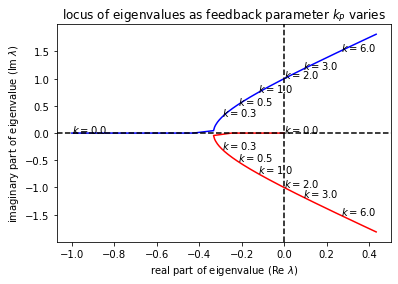

In [6]:
kps = np.linspace(0,10,1000)
lambda1 = eig1(kps)
lambda2 = eig2(kps)

#Axis labels
plt.title('locus of eigenvalues as feedback parameter $k_P$ varies')
plt.xlabel(r'real part of eigenvalue ($\operatorname{Re}\ \lambda$)')
plt.ylabel(r'imaginary part of eigenvalue ($\operatorname{Im}\ \lambda$)')

#Plotting values
plt.plot(lambda1.real,lambda1.imag,color='b')
plt.plot(lambda2.real,lambda2.imag,color = 'r')
# we'll only annotate every 10 of the computed eigenvalues
for i in [0,25,50,100,200,300,600]:
  plt.annotate(r'$k=%0.1f$'%kps[i],xy=(lambda1[i].real,lambda1[i].imag))
  plt.annotate(r'$k=%0.1f$'%kps[i],xy=(lambda2[i].real,lambda2[i].imag))

#x- and y- limits and drawing axes
ylim = plt.ylim()
plt.plot(np.zeros(2),ylim,'k--')
xlim = plt.xlim()
plt.plot(xlim,np.zeros(2),'k--')
plt.xlim(xlim); plt.ylim(ylim);

In [8]:
# pick k = 1.1

C = .2
Ls = P*C
L = sym.lambdify(s,Ls)
Ls

0.2/(s*(s + 1)**2)

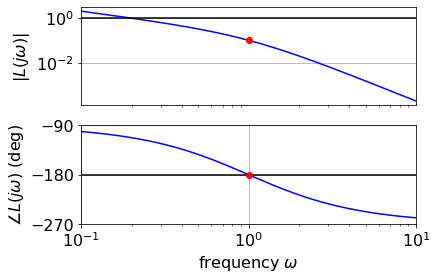

In [9]:
omega = np.logspace(-1,1,1000)
xlim = omega[[0,-1]]

abs_L = np.abs(L(1.j*omega))
angle_L = np.unwrap(np.angle(L(1.j*omega)))*180./np.pi

critical = (angle_L < -180).nonzero()[0][0]

plt.figure(); axs = []
ax = plt.subplot(2,1,1); ax.grid('on')
ax.loglog(omega,abs_L,'b-')
ax.loglog(xlim,[1.,1.],'k-')
ax.loglog(omega[critical],abs_L[critical],'ro')
ax.set_ylabel(r'$|L(j\omega)|$')
ax.set_xticks([])
ax.set_xlim(xlim)
axs.append(ax)

ax = plt.subplot(2,1,2); ax.grid('on')
ax.semilogx(omega,angle_L,'b-')
ax.semilogx(xlim,[-180.,-180.],'k-')
ax.semilogx(omega[critical],angle_L[critical],'ro')
ax.set_xlabel(r'frequency $\omega$')
ax.set_ylabel(r'$\angle L(j\omega)$ (deg)')
ax.set_yticks([-90,-180,-270])
ax.set_xlim(xlim)
axs.append(ax)

for ax in axs:
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
               ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(16)

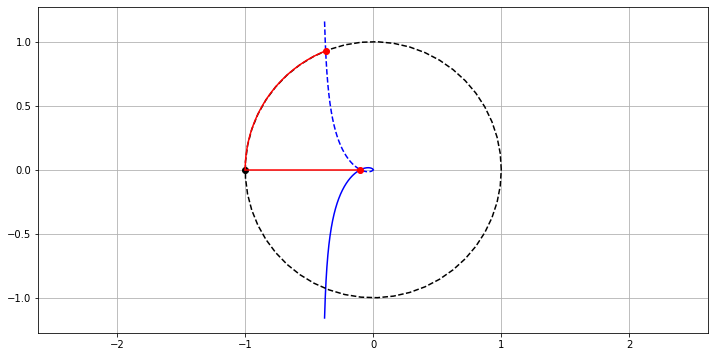

In [99]:
import scipy.optimize as opt
omega = np.linspace(0.16,10,10000)
Omega = L(1.j*omega)
abs_L = np.abs(Omega)
angle_L = np.angle(Omega)*180/np.pi
circle = np.exp(1.j*np.linspace(0.,2*np.pi))

# numerical value of stability margin
# find gain margin
# looking for a frequency that results in L(jw) on the real axis
f = lambda x: L(1.j*x).imag
omega_g_m = opt.root_scalar(f, method='bisect', bracket=[0.16,10]).root
g_m = 1./np.abs(L(1.j*omega_g_m))

# find phase margin
# looking for intersection of L(jw) with unit circle
f = lambda x: np.abs(L(1.j*x))-1.
omega_theta_m = opt.root_scalar(f, method='bisect', bracket=[0.16,10]).root
theta_m = (np.angle(L(1.j*omega_theta_m))+np.pi)*180/np.pi
# axs = []

plt.figure(figsize=(12,6))
ax = plt.subplot(1,1,1); ax.grid('on'); ax.axis('equal')

# Omega, i.e. graph of L(j omega)
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')

# unit circle
ax.plot(circle.real,circle.imag,'k--')

# gain margin
ax.plot(-1./g_m,0.,'ro',label=r'$-1/g_m$')
ax.plot(-1.,0.,'ko',label=r'critical point $-1\in\mathbb{C}$')
# add straight line to show margin
x = np.linspace(-1./g_m,-1,100) + 0.j
ax.plot(x.real, x.imag, 'r')

# phase margin
ax.plot(L(1.j*omega_theta_m).real, -L(1.j*omega_theta_m).imag, 'ro', label=r'$foo$')
# add semicircular arc to show the angle
theta = np.linspace(np.angle(L(1.j*omega_theta_m)),-np.pi,100)
ax.plot(np.cos(theta), -np.sin(theta), 'r')

# # legend and labels
ax.legend(fontsize=14,frameon=True,shadow=True)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');
axs.append(ax)

# for ax in axs:
#   for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#                ax.get_xticklabels() + ax.get_yticklabels()):
#       item.set_fontsize(16)

In [89]:
theta_m

68.1712415844168

In [74]:
g_m_idx

9949